# Cleaning the dataset

In [149]:
# Installing required packages
!pip3 install pandas
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install scipy


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip


In [197]:
#Importing libraries

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from functools import reduce
from scipy import stats

# 1. Loading the datasets

In [151]:
dir = os.chdir('/Users/justina/Desktop/Data Science') # Set working directory (where the folder is)

data_files_names = glob.glob('data/sharew8_rel9-0-0_??.dta') # Lists all data in the folder


In [193]:
#data_files_names

### 1.1 Load the data that contains information about the retirement status only.

We only use 2 columns from "Employment and pensions" dataset because the "retired" people are only asked about the pensions they are receiving, which is not relevant/suitable for our analysis.

In [152]:
ret = pd.read_stata('data/sharew8_rel9-0-0_ep.dta')

# Filter retirement dataset so that only the retired people are included.

ret = ret[ret["ep005_"] == "Retired"]
new_ret = ret[["mergeid", "ep005_", "ep329_"]] # This creates a new df, which we will use for merging other dfs to.

#new_ret #(34521, 2)

In [153]:
# Now, remove unnecessary datasets from the dataset list

data_files_names.remove('data/sharew8_rel9-0-0_ep.dta') # Because we have it already loaded.
data_files_names.remove('data/sharew8_rel9-0-0_xt.dta') # Answered by proxies.
data_files_names.remove('data/sharew8_rel9-0-0_iv.dta') # Answered by proxies.

### 1.2 Load the rest of the datasets: merge them on "mergeid"

The code below takes ~ 13 seconds to run. We end up with 2767 columns in total.

In [154]:
# Looping through datasets. 
# We load each dataset, and merge the data to the new_ret dataset only if that column is not present there already (like other ID columns)

for file_name in data_files_names:
    # Load each dataset
    data = pd.read_stata(file_name)
    
    # Create a list of columns to keep (those that are not already in new_ret)
    columns_to_keep = []
    for column in data.columns:
        if column not in new_ret.columns or column == "mergeid":
            columns_to_keep.append(column)
    
    # Subset the data to keep only the relevant columns
    data = data[columns_to_keep]
    
    # Merge the dataset with new_ret
    new_ret = pd.merge(new_ret, data, on='mergeid', how='inner')

In [155]:
new_ret.shape

(34521, 2767)

# 2. Calculate the age of the respondent

In [156]:
# Ensure the the year of birth and year of retirement are numerical values

new_ret['dn003_'] = pd.to_numeric(new_ret['dn003_'], errors='coerce')
new_ret['ep329_'] = pd.to_numeric(new_ret['ep329_'], errors='coerce')

In [157]:
new_ret['age_ret'] = new_ret['ep329_'] - new_ret['dn003_']

print(new_ret['age_ret'].describe()) # summary

count    23073.000000
mean        59.184111
std          6.667283
min          8.000000
25%         56.000000
50%         60.000000
75%         63.000000
max         91.000000
Name: age_ret, dtype: float64


In [158]:
# Remove rows where 'age_ret' is NaN and overwrite df_merged_retired

new_ret = new_ret[new_ret['age_ret'].notna()]

# Check shape to confirm

print(new_ret.shape) # (23073, 2768)

(23073, 2768)


Plot of the distribution of age:

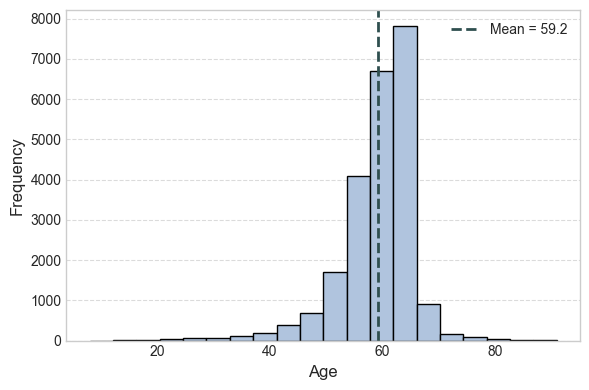

In [159]:
plt.style.use("seaborn-v0_8-whitegrid")

age_data = new_ret['age_ret']
mean_age = age_data.mean()

fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(age_data, bins=20, edgecolor='black', color='lightsteelblue')

ax.axvline(mean_age, color='darkslategray', linestyle='--', linewidth=2, label=f'Mean = {mean_age:.1f}')

ax.set_xlabel("Age", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)

ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.grid(axis='x', visible=False)
ax.legend()
plt.tight_layout()
plt.savefig("/Users/justina/Desktop/Data Science/plots/age_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. Data clean-up: NAs

First, we remove columns and rows that at least 50 % of data missing:

In [160]:
data_clone = new_ret

In [162]:
# If columns contain more than 50% of data missing, we remove those columns:

# List to hold columns to drop
columns_to_drop = []

# Loop through each column
for column in data_clone.columns:
    missing_values = data_clone[column].isna().sum() # Calculates the total number of NAs within the column
    if missing_values > data_clone.shape[0] * 0.5:
        columns_to_drop.append(column)

# Drop the columns all at once
data_clone = data_clone.drop(columns=columns_to_drop)

In [163]:
data_clone.shape # (23073, 415)

(23073, 415)

Dropping columns with 50 % of the data missing has reduced the features from 2768 to 415.

In [164]:
# List to hold indices of rows to drop
rows_to_drop = []

# Loop through each row
for index, row in data_clone.iterrows():
    missing_values = row.isna().sum()  # Calculates the total number of NAs in the row
    if missing_values > data_clone.shape[1] * 0.5:
        rows_to_drop.append(index)

# Drop the rows all at once
data_clone = data_clone.drop(index=rows_to_drop)

In [165]:
data_clone.shape # (23073, 415)

(23073, 415)

Dropping rows with 50% of the data missing did not influence the shape of the data, meaning that respondents answered at least half of the questions.

As there are still columns with more that 4k values missing, we remove them further.

In [166]:
# List to hold columns to drop
columns_to_drop = []

# Loop through each column
for column in data_clone.columns:
    missing_values = data_clone[column].isna().sum() # Calculates the total number of NAs within the column
    if missing_values > data_clone.shape[0] * 0.1:
        columns_to_drop.append(column)

# Drop the columns all at once
data_clone = data_clone.drop(columns=columns_to_drop)

In [167]:
data_clone.shape # (23073, 273)

(23073, 273)

After removing columns that are missing at least 10 % of data (around 2308 observations), we end u with a dataframe of 23073 rows (participants) and 273 features.

In [168]:
na = [col for col in data_clone.columns if data_clone[col].isna().any()]
print(len(na))

59


Now, only 59 columns contain NAs.

The code below contains a dictionary - which shows the columns that are missing values and how much of them are missing.

In [169]:
missing_retirement_info = {
    col: data_clone[col].isna().sum()
    for col in data_clone.columns
    if data_clone[col].isna().any()
}

missing_retirement_info = dict(
    sorted(missing_retirement_info.items(), key=lambda item: item[1], reverse=True)
)


In [170]:
missing_retirement_info

{'gs008_': np.int64(2147),
 'gs009_': np.int64(2147),
 'gs006_': np.int64(2143),
 'gs007_': np.int64(2143),
 'hc116d1': np.int64(2047),
 'hc876_': np.int64(2027),
 'hc877_': np.int64(2027),
 'cf112_': np.int64(2001),
 'cf111_': np.int64(1772),
 'gs002_': np.int64(1659),
 'gs012_': np.int64(1659),
 'gs013_': np.int64(1659),
 'gs014_': np.int64(1659),
 'sn006_1': np.int64(1583),
 'cf110_': np.int64(1459),
 'ch021_': np.int64(1256),
 'sn005_1': np.int64(1004),
 'sn009_1': np.int64(1004),
 'cf109_': np.int64(968),
 'sn012_': np.int64(830),
 'ac021_': np.int64(820),
 'cf010_': np.int64(451),
 'ex009_': np.int64(16),
 'ex001_': np.int64(13),
 'ac035d1': np.int64(9),
 'ac035d4': np.int64(9),
 'ac035d5': np.int64(9),
 'ac035d7': np.int64(9),
 'ac035d8': np.int64(9),
 'ac035d9': np.int64(9),
 'ac035d10': np.int64(9),
 'ac035dno': np.int64(9),
 'ac740_': np.int64(9),
 'ac022_': np.int64(8),
 'ac023_': np.int64(8),
 'ac024_': np.int64(8),
 'ac025_': np.int64(8),
 'ac012_': np.int64(7),
 'ac014_':

For the simplicity, the features with more than a 450 values missing will be further removed.

In [171]:
test_df = data_clone.loc[:, data_clone.isna().sum() <= 450]

In [172]:
missing_retirement_info_test = {
    col: test_df[col].isna().sum()
    for col in test_df.columns
    if test_df[col].isna().any()
}

missing_retirement_info_test = dict(
    sorted(missing_retirement_info_test.items(), key=lambda item: item[1], reverse=True)
)

In [173]:
missing_retirement_info_test

{'ex009_': np.int64(16),
 'ex001_': np.int64(13),
 'ac035d1': np.int64(9),
 'ac035d4': np.int64(9),
 'ac035d5': np.int64(9),
 'ac035d7': np.int64(9),
 'ac035d8': np.int64(9),
 'ac035d9': np.int64(9),
 'ac035d10': np.int64(9),
 'ac035dno': np.int64(9),
 'ac740_': np.int64(9),
 'ac022_': np.int64(8),
 'ac023_': np.int64(8),
 'ac024_': np.int64(8),
 'ac025_': np.int64(8),
 'ac012_': np.int64(7),
 'ac014_': np.int64(7),
 'ac015_': np.int64(7),
 'ac016_': np.int64(7),
 'ac017_': np.int64(7),
 'ac018_': np.int64(7),
 'ac019_': np.int64(7),
 'ac020_': np.int64(7),
 'sn002a_1': np.int64(4),
 'sn002a_2': np.int64(4),
 'sn002a_3': np.int64(4),
 'sn002a_4': np.int64(4),
 'sn002a_5': np.int64(4),
 'sn002a_6': np.int64(4),
 'sn003a_': np.int64(4),
 'ex009age': np.int64(3),
 'sp002_': np.int64(3),
 'sp008_': np.int64(3),
 'sp022_': np.int64(3),
 'it004_': np.int64(1),
 'gs701_': np.int64(1),
 'dn002_': np.int64(1)}

In [174]:
test_df.shape

(23073, 251)

Second, we remove any observations (row-wise) that contain NAs:

In [175]:
retirement = test_df.dropna()

In [176]:
retirement.shape

(23052, 251)

In [177]:
retirement.isna().any().any() # No NAs

np.False_

Done. Now we have 23052 participants (good for generalizability) and 251 that we still need to "look through".

# 4. Remove unnecessary columns

In [179]:
retirement.columns

Index(['mergeid', 'ep005_', 'ep329_', 'hhid8', 'mergeidp8', 'coupleid8',
       'country', 'language', 'cf003_', 'cf004_',
       ...
       'ac035d1', 'ac035d4', 'ac035d5', 'ac035d7', 'ac035d8', 'ac035d9',
       'ac035d10', 'ac035dno', 'ac740_', 'age_ret'],
      dtype='object', length=251)

In [180]:
final = retirement.drop(columns=["ep005_", # remove the status of retirement, 
                                 "dn003_", # remove year of birth
                                 "ep329_", # remove year of retirement
                                 "hhid8", "mergeidp8", "coupleid8", "language", #remove unnecessary IDs and language
                                 "mh032_", # remove another unnecessary variable (intro something)
                                 "sn_childid_1", 
                                 "sn_childid_2", 
                                 "sn_childid_3", 
                                 "sn_childid_4", 
                                 "sn_childid_5", 
                                 "sn_childid_6", 
                                 "sn_childid_7"])

In [181]:
childid_columns = [col for col in final.columns if col.startswith('childid')]
print(childid_columns)

['childid_1', 'childid_2', 'childid_3', 'childid_4', 'childid_5', 'childid_6', 'childid_7', 'childid_8', 'childid_9', 'childid_10', 'childid_11', 'childid_12', 'childid_13', 'childid_14', 'childid_15', 'childid_16', 'childid_17', 'childid_18', 'childid_19', 'childid_20']


In [182]:
final = final.drop(columns = childid_columns)

In [183]:
final.shape #23052 rows, 216 columns

(23052, 216)

Remove the outliers from the data:

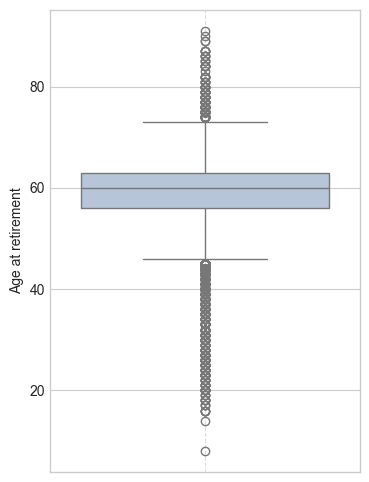

In [ ]:
# First, we plot the outliers:

plt.figure(figsize=(4, 6))

sns.boxplot(y=final['age_ret'], color='lightsteelblue')

plt.ylabel('Age at retirement')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.savefig("/Users/justina/Desktop/Data Science/plots/age_outliers.png", dpi=300, bbox_inches='tight')
plt.show()


As there are quite a lot outliers, we will remove them with a z-score method. Therefore, any observation that is more than 3 SD away will be removed from the dataset.

In [143]:
z_scores = stats.zscore(final['age_ret'])
final_clean = final[(abs(z_scores) < 3)]

In [217]:
print(final_clean['age_ret'].describe()) # summary

count    22658.000000
mean        59.575735
std          5.568619
min         40.000000
25%         56.000000
50%         60.000000
75%         64.000000
max         79.000000
Name: age_ret, dtype: float64


In [218]:
final_clean.shape

(22658, 216)

Now, the plot below visualizes age distribution once the outliers are removed.

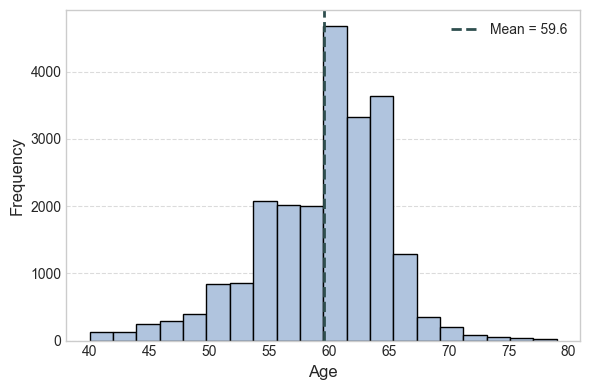

In [147]:
plt.style.use("seaborn-v0_8-whitegrid")

final_clean_data = final_clean['age_ret']
mean_age_final_clean = final_clean_data.mean()

fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(final_clean_data, bins=20, edgecolor='black', color='lightsteelblue')

ax.axvline(mean_age_final_clean, color='darkslategray', linestyle='--', linewidth=2, label=f'Mean = {mean_age_final_clean:.1f}')

ax.set_xlabel("Age", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)

ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.grid(axis='x', visible=False)
ax.legend()
plt.tight_layout()
plt.savefig("/Users/justina/Desktop/Data Science/plots/age_distribution_z_scored.png", dpi=300, bbox_inches='tight')
plt.show()

# 5. Save the data:

In [219]:
# Save retirement data as CSV file

final_clean.to_csv("/Users/justina/Desktop/Data Science/retirement_data_all.csv", index=False)


# 6. Extra plots:

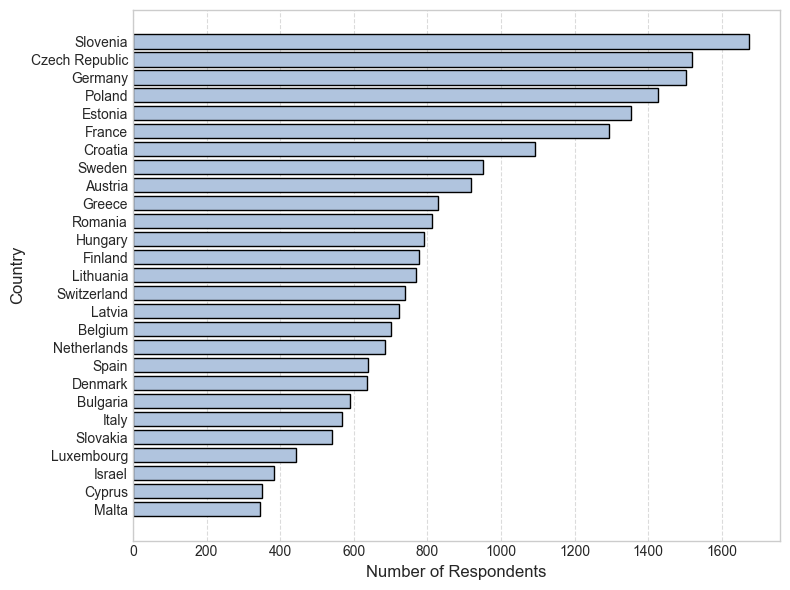

In [220]:
plt.style.use("seaborn-v0_8-whitegrid")

country_counts = final['country'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(8, 6))

# Horizontal bar plot
ax.barh(country_counts.index, country_counts.values, color='lightsteelblue', edgecolor='black')

ax.set_ylabel("Country", fontsize=12)
ax.set_xlabel("Number of Respondents", fontsize=12)

ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.grid(axis='y', visible=False)

plt.tight_layout()
plt.savefig("/Users/justina/Desktop/Data Science/plots/respondents_by_country.png", dpi=300, bbox_inches='tight')
plt.show()
